In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import textblob
%matplotlib inline

import datetime 
import lightgbm
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from wordcloud import WordCloud
import random
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score


# Stock Market Data

In [2]:
stock_df = pd.read_csv('historical-data.csv', parse_dates= ["Date"])
stock_df.columns = stock_df.columns.str.lower()
# mask = (stock_df['date'] > '2016-02-17') & (data['date'] <= '2020-05-23')
# stock_df = stock_df.loc[mask]
stock_df.head()

0      2016-02-17
1      2016-02-18
2      2016-02-19
3      2016-02-22
4      2016-02-23
          ...    
1229   2021-02-10
1230   2021-02-11
1231   2021-02-12
1232   2021-02-15
1233   2021-02-16
Name: date, Length: 1234, dtype: datetime64[ns]

In [4]:
plot = []
price_df = stock_df.groupby('date')[['close', 'open']].quantile(0.5).reset_index()

plot.append(go.Scatter(
x = price_df['date'].dt.strftime(date_format='%Y-%m-%d').values,
y = price_df['close'].values,
name = f'Close prices' ))
plot.append(go.Scatter(
x = price_df['date'].dt.strftime(date_format='%Y-%m-%d').values,
y = price_df['open'].values,
name = f'Open prices' ))
layout = go.Layout(dict(title = "Trends of Open and Closing prices",
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Price'),
                       ), legend = dict(orientation = 'h'))
py.iplot(dict(data = plot, layout = layout), filename = 'basic-line')

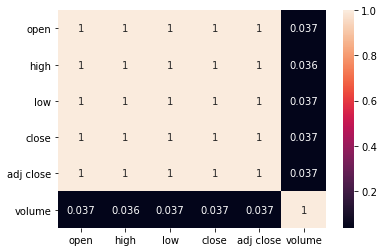

In [5]:
corrMatrix = stock_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [8]:
stock_df['close_to_open'] = np.abs(stock_df['close']/stock_df['open'])
print(f"In {(stock_df['close_to_open'] >= 1.02).sum()} lines price increased by 2% or more.")
print(f"In {(stock_df['close_to_open'] <= 0.98).sum()} lines price decreased by 2% or more.")

In 13 lines price increased by 2% or more.
In 29 lines price decreased by 2% or more.


# News data Analysis

In [9]:
news = pd.read_csv('india-news-headlines.csv',parse_dates = ["publish_date"])
news.columns = news.columns.str.lower()
news.dropna(axis = 0,inplace = True)
news.drop('headline_category' ,axis = 1,inplace = True)
news_og = news.copy()
news.head()

,publish_date,headline_text
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa


In [10]:
news.isna().sum()

publish_date     0
headline_text    0
dtype: int64

In [11]:
news.duplicated().value_counts()

False    3154916
True      142256
dtype: int64

In [12]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 0 to 3297171
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   publish_date   datetime64[ns]
 1   headline_text  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 75.5+ MB


In [13]:
cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)
news.duplicated(keep = False)
news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [14]:
news.duplicated().value_counts()

False    3154916
dtype: int64

In [15]:
# only including relevant news from the dataset
mask = (news['publish_date'] > '2016-02-17') & (news['publish_date'] <= '2021-02-16')
news = news.loc[mask]
news.head()

,publish_date,headline_text
2199213,2016-02-18,'Juvenile' hangs self at home
2199214,2016-02-18,'Loveshhuda' is a musical romcom with Quirkiness
2199215,2016-02-18,'Neerja' producer: Atul Kasbekar: Multitasking...
2199216,2016-02-18,'Rhythm' actress: Coming to Vadodara is very s...
2199217,2016-02-18,'Where's the SC now; lawyers taunted me'


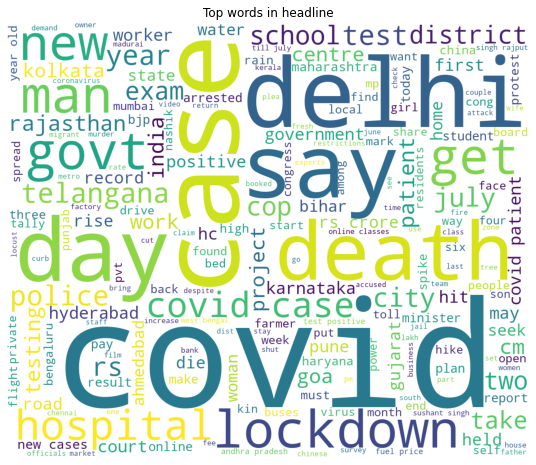

In [17]:
text = ' '.join(news['headline_text'].str.lower().values[-1000:])
wordcloud = WordCloud(max_font_size=None, stopwords = stop, background_color='white',
                     width = 1200, height = 1000).generate(text)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

In [18]:
import string
news['nwords'] = news['headline_text'].str.split().map(len)
news['nsentences'] = news['headline_text'].str.count('.')
news.head()

,publish_date,headline_text,nwords,nsentences
2199213,2016-02-18,'Juvenile' hangs self at home,5,29
2199214,2016-02-18,'Loveshhuda' is a musical romcom with Quirkiness,7,48
2199215,2016-02-18,'Neerja' producer: Atul Kasbekar: Multitasking...,9,68
2199216,2016-02-18,'Rhythm' actress: Coming to Vadodara is very s...,8,52
2199217,2016-02-18,'Where's the SC now; lawyers taunted me',7,40


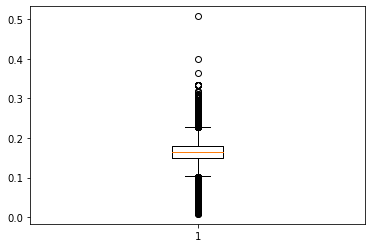

In [19]:
news['sentence_word_count'] =  news['nwords'] / news['nsentences']
plt.boxplot(news['sentence_word_count'][news['sentence_word_count'] < 40]);

## Market Sentiment

In [20]:
index_sensex=news['headline_text'].str.match(r'(?=.*\bmarket\b).*$',case=False)
data_sensex=news.loc[index_sensex].copy()
data_sensex['polarity']=data_sensex['headline_text'].map(lambda x: textblob.TextBlob(x).sentiment.polarity).fillna(method = 'bfill')
data_sensex['subjectivity']=data_sensex['headline_text'].map(lambda x: textblob.TextBlob(x).sentiment.subjectivity).fillna(method = 'bfill')

news['polarity'] = data_sensex['polarity']
news['subjectivity'] = data_sensex['subjectivity']

In [21]:
pos = data_sensex.query("polarity>0")['headline_text']
neg = data_sensex.query("polarity<0")['headline_text']
print(f"The number of postive headlines were {round(len(pos)/len(neg),2)} times the negative headlines")

The number of postive headlines were 1.49 times the negative headlines


Text(0.5, 1.0, 'Frequency of Positive and Negative News about market')

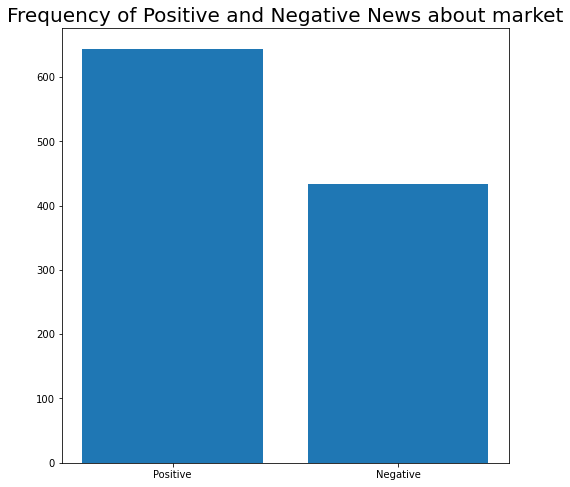

In [22]:
plt.figure(figsize=(8,8))
plt.bar(["Positive","Negative"],[len(pos),len(neg)])
plt.title("Frequency of Positive and Negative News about market",fontsize=20)

In [25]:
stock_df['price_diff'] = stock_df['close'] - stock_df['open']
grouped = stock_df.groupby('date').agg({'price_diff': ['std', 'min']}).reset_index()

In [37]:
def data_prep(market_df, news_df):
    market_df['close_to_open'] = market_df['close'] / market_df['open']
    market_df['volume_to_mean'] = market_df['volume'] /  market_df['volume'].mean()
    news_df['sentence_word_count'] = news_df['nwords'] / news_df['nsentences']
    stock_df["month"] = stock_df['date'].dt.month
    stock_df["day"] = stock_df['date'].dt.day
    stock_df["dayofweek"] = stock_df['date'].dt.dayofweek
    stock_df["week"] = stock_df['date'].dt.week
    stock_df['movingavg4weeks'] = round(stock_df['close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
    stock_df['movingavg16weeks'] = round(stock_df['close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
    stock_df['movingavg28weeks'] = round(stock_df['close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
    stock_df['movingavg40weeks'] = round(stock_df['close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
    stock_df['movingavg52weeks'] = round(stock_df['close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2) 
    stock_df['window10days'] = round(stock_df['close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
    stock_df['window50days'] = round(stock_df['close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
    news_df['polarity'] = round(news_df['polarity'] , 2)
    news_df['subjectivity'] = round(news_df['subjectivity'] , 2)
    stock_df['price'] = round((stock_df['high'] + stock_df['low'] + stock_df['close']) / 3 , 2)
    stock_df['close'] = round(stock_df['close'] , 2)
    news_df['headlinelen'] = news_df['headline_text'].apply(lambda x:len(x))
    news_df['sentence_mean'] = news_df.groupby('nsentences')['date'].transform('count')
    market_df = pd.merge(market_df,news_df, how = 'outer', on = ['date'] )
    market_df = market_df.dropna(axis = 0).reset_index(drop = True)
    return market_df
news.rename(columns = {'publish_date': 'date'}, inplace = True)
market_train = data_prep(stock_df, news)
market_train.head()

<ipython-input-37-842875b9a7d4>:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,date,open,high,low,close,adj close,volume,close_to_open,price_diff,volume_to_mean,...,window50days,price,headline_text,nwords,nsentences,sentence_word_count,polarity,subjectivity,headlinelen,sentence_mean
0,2016-02-18,23536.470703,23735.349609,23448.210938,23649.22,23649.220703,15700.0,1.004790,112.750000,0.057266,...,23381.87,23610.93,Government bans energy guzzling one-star air-c...,10.0,78.0,0.128205,0.0,0.00,78.0,5256.0
1,2016-02-18,23536.470703,23735.349609,23448.210938,23649.22,23649.220703,15700.0,1.004790,112.750000,0.057266,...,23381.87,23610.93,Land for metro: Residents to get twice market ...,12.0,68.0,0.176471,0.0,0.00,68.0,12156.0
2,2016-02-18,23536.470703,23735.349609,23448.210938,23649.22,23649.220703,15700.0,1.004790,112.750000,0.057266,...,23381.87,23610.93,Tribunal stays demolition order against illega...,8.0,62.0,0.129032,-0.4,0.45,62.0,18861.0
3,2016-02-19,23640.320313,23774.480469,23508.359375,23709.15,23709.150391,11600.0,1.002912,68.830078,0.042311,...,23515.54,23664.00,PM gives farmers an online market,6.0,33.0,0.181818,0.0,0.00,33.0,11365.0
4,2016-02-19,23640.320313,23774.480469,23508.359375,23709.15,23709.150391,11600.0,1.002912,68.830078,0.042311,...,23515.54,23664.00,Sebi wants retail participation in stock market,7.0,47.0,0.148936,0.2,0.10,47.0,26029.0


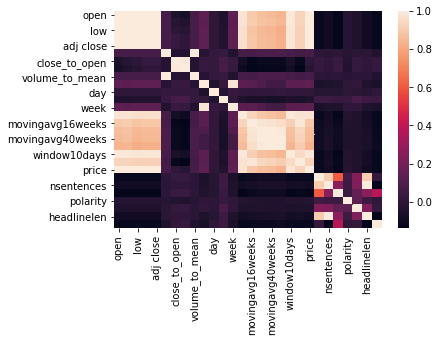

In [31]:
corrMatrix = market_train.corr()
sns.heatmap(corrMatrix)
plt.show()

In [46]:
market_train.isna().mean()
fcol = [c for c in market_train.columns if c not in [ 'time', 'date','title','headline_text' ,'description','price', 'close', 'adj close']]
X = market_train[fcol].values
y = market_train.close

# Scaling of X values
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)



In [47]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=99)

In [48]:
def training_model(X_train, y_train):
    model = lightgbm.LGBMRegressor(metric = "rmse")
    
    parameters = {
        'max_depth' : [6, 8, 10, 12],
        'learning_rate' : [0.01, 0.05, 0.03, 0.01],
        'num_leaves' : [22, 100, 600, 2500],
        'num_iteration' : [1000, 5000, 10000],
        'n_estimators': [100, 300, 500],
    }
    
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 5,
                       verbose = 1, n_jobs = -1, refit = True)
    
    grid.fit(X_train, y_train)
    
    print("Results from Grid Search")
    print(f"Best Estimator across all searched params is {grid.best_estimator_}")
    print(f"Best parameters across all searched params is {grid.best_params_}")    
    
    parameters = {
        'max_depth' : random.randint(6, 12),
        'learning_rate': random.uniform(0.1, 0.9),
        'num_iteration' : random.randint(1000, 10000),
        'num_leaves' : random.randint(22,2500),
        'n_estimators' : random.randint(100, 1000),
    }
    
    rand = RandomizedSearchCV(estimator = model, param_distributions=parameters,
                             cv = 5, n_iter = 10, verbose = 1, n_jobs = -1)
    rand.fit(X_train, y_train)
    
    print("Results from Random Search")
    print(f"Best Estimator across all searched params is {rand.best_estimator_}")
    print(f"Best parameters across all searched params is {rand.best_params_}")    
    
    if grid.best_score_ > rand.best_score_:
        print("Found better results with grid search")
        return grid.best_estimator_
    else:
        print("Found better results with random search")
        return rand.best_estimator_
        

In [49]:
model = training_model(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 38.1min
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 57.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 84.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 116.6min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 144.8min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=10000, num_iteration=10000 will be ignored. Current value: num_iterations=10000
Results from Grid Search
Best Estimator across all searched params is LGBMRegressor(learning_rate=0.03, max_depth=12, metric='rmse',
              num_iteration=10000, num_leaves=22)
Best parameters across all searched params is {'learning_rate': 0.03, 'max_depth': 12, 'n_estimators': 100, 'num_iteration': 10000, 'num_leaves': 22}


NameError: name 'params' is not defined

In [ ]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: np.random.randint(0, 255), range(3)))
    return color

df = pd.DataFrame({'imp': model.feature_importance(), 'col':fcol})
df = df.sort_values(['imp','col'], ascending=[True, False])
importance_df = [df]
for dd in importance_df:  
    colors = []
    for i in range(len(dd)):
         colors.append(generate_color())

    data = [
        go.Bar(
        orientation = 'h',
        x=dd.imp,
        y=dd.col,
        name='Features',
        textfont=dict(size=20),
            marker=dict(
            color= colors,
            line=dict(
                color='#000000',
                width=0.5
            ),
            opacity = 0.87
        )
    )
    ]
    layout= go.Layout(
        title= 'Feature Importance of LGB',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis=dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )

    py.iplot(dict(data=data,layout=layout), filename='horizontal-bar')

In [ ]:
model.save_model('lgb_classifier.txt', num_iteration=model.best_iteration) 